In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sns
import plotly.express as px
from collections import defaultdict
import time
from xgboost import XGBClassifier
from IPython.display import display

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook"
# import plotly
# print(plotly.__version__)
# # import plotly.offline as pyo
# # pyo.init_notebook_mode(connected=True)

In [3]:
# data_500 = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/data_500k.csv", low_memory=False)
# data_500.sample(5)

In [4]:
data_500 = pd.read_csv("data/data_500k.csv")
def clean_party_create_infer(corrected_data):
    #Replace blanks and spaces with NaN
    corrected_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'SD'
    corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    # Update the 'U' values in PARTY_CODE to 'N' for rows where STATE is in ['DC', 'LA', 'RI']
    states_to_update = ['DC', 'LA', 'RI']
    corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'

    # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'OK'
    corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    print("N's after corrections")
    print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['N'])]))

    print("U's after corrections")
    print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['U'])]))

    print("inferred Rs:")
    print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['S'])]))

    print("inferred Ds:")
    print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['E'])]))

    # Define function to infer party based on given conditions
    def set_inferred_party(row):
        not_in_list = ['D', 'R', 'M', 'P', 'X', 'Z']
        rpx = ['R', 'P', 'X']
        dmz = ['D', 'M', 'Z']
        if row['PARTY_CODE'] not in ['D', 'R','E','S']:
            if (
               (row['FUND_POLIT'] == 'R' or row['DON_POLCONS'] or row['PRFL_HEALTHCARE_REFORM'] == '2' or
                row['PRFL_2NDAMEND'] == 'Y' or row['PRFL_CHOICELIFE'] == '1') and row['FUND_POLIT'] != 'D' and
                not row['DON_POLLIB'] and all(row[col] not in not_in_list for col in
                ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]])
           ) or (
               sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]]
                if row[col] in rpx) > sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] +
                ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in dmz)
           ):
                return 'S'
            elif (
               (row['FUND_POLIT'] == 'D' or row['DON_POLLIB'] or row['PRFL_HEALTHCARE_REFORM'] == '1' or
                row['PRFL_CHOICELIFE'] == '2') and row['FUND_POLIT'] != 'R' and not row['DON_POLCONS'] and
                all(row[col] not in not_in_list for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] +
                ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]])
           ) or (
               sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]]
                if row[col] in rpx) < sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] +
                ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in dmz)
           ):
                return 'E'
        return row['PARTY_CODE']

    # Applying the function
    corrected_data['PARTY_CODE'] = corrected_data.apply(set_inferred_party, axis=1)

    print("new inferred Rs:")
    print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['S'])]))

    print("new inferred Ds:")
    print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['E'])]))


    # Create party_mapping using defaultdict.Lambda sets default (all other non-D and non-R party registrations to NaN.
    infer_party_mapping = defaultdict(lambda: float('nan'))
    infer_party_mapping.update({
        'D': 'D',  # Registered Democrats are mapped to Democrat
        'E': 'D',  # E (Inferred Democrats) are mapped to Democrat
        'R': 'R',  # Registered Republicans are mapped to Republican 
        'S': 'R'   # S (Inferred Republicans) are mapped to Republican
    })
    # Map PARTY_CODE to INFER_PARTY
    corrected_data['INFER_PARTY'] = corrected_data['PARTY_CODE'].map(infer_party_mapping)

    # Define the mapping for PARTY_CODE modifications
    party_code_mapping = {
        'E': float('nan'),
        'S': float('nan'),
        'U': float('nan'),
        'A': 'O',
        'B': 'O',
        'C': 'O',
        'F': 'O',
        'G': 'O',
        'H': 'O',
        'I': 'O',
        'J': 'O',
        'K': 'O',
        'L': 'L',
        'P': 'O',
        'Q': 'O',
        'T': 'O',
        'V': 'O',
        'W': 'O',
        'Y': 'O',
        'Z': 'O'
    }
    # Apply the mapping to the PARTY_CODE column
    corrected_data['PARTY_CODE'] = corrected_data['PARTY_CODE'].replace(party_code_mapping)

    print("Final PARTY_CODE values:")
    print(corrected_data['PARTY_CODE'].unique())
    print('Final INFER_PARTY values:')
    print(corrected_data['INFER_PARTY'].unique())
    print('INFER_PARTY Ds and Rs:')
    print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
    print('INFER_PARTY NaNs:')
    print(corrected_data['INFER_PARTY'].isna().sum())

    voter_columns = [col for col in corrected_data.columns if col.startswith("VTR")]

    #Create column with total number of votes in voter_columns per row
    #corrected_data['VTR_TOTAL_VOTES'] = corrected_data[voter_columns].notnull().sum(axis=1)

    #Sum Democrat and Republican totals
    corrected_data['VTR_TOTAL_DVOTES'] = corrected_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
    corrected_data['VTR_TOTAL_RVOTES'] = corrected_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)

    #Create conditions that evaluate whether someone has cast at least two more votes for Democrats or Republicans: 
    conditions = [
        corrected_data['VTR_TOTAL_DVOTES'] - corrected_data['VTR_TOTAL_RVOTES'] >= 2,
        corrected_data['VTR_TOTAL_RVOTES'] - corrected_data['VTR_TOTAL_DVOTES'] >= 2
    ]

    choices = ['D', 'R']

    corrected_data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
    corrected_data['VTR_INFER_PARTY'].replace('nan', np.nan, inplace=True)

    # Assign a 'D' or an 'R' to INFER_PARTY if either condition is true:
    corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'D') , 'INFER_PARTY'] = 'D'
    corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'R') , 'INFER_PARTY'] = 'R'
    corrected_data.drop(columns=["VTR_INFER_PARTY", "VTR_TOTAL_DVOTES", "VTR_TOTAL_RVOTES"], inplace=True)

    print('Final INFER_PARTY Ds and Rs:')
    print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
    print('Final INFER_PARTY NaNs:')
    print(corrected_data['INFER_PARTY'].isna().sum())

    return corrected_data
engineered_data = clean_party_create_infer(data_500)

C:\Users\Hernando\AppData\Local\Temp\ipykernel_6188\2482597874.py:1: DtypeWarning:

Columns (22,56,58,86,93,117,144,146,148,150,159,164,169,171,178,192,193,205,214,215,241,293,297) have mixed types. Specify dtype option on import or set low_memory=False.



N's after corrections
75028
U's after corrections
69537
inferred Rs:
78296
inferred Ds:
71769
new inferred Rs:
81680
new inferred Ds:
76795
Final PARTY_CODE values:
['N' 'R' 'O' 'D' 'L' nan]
Final INFER_PARTY values:
[nan 'R' 'D']
INFER_PARTY Ds and Rs:
354058
INFER_PARTY NaNs:
145942
Final INFER_PARTY Ds and Rs:
354080
Final INFER_PARTY NaNs:
145920


In [5]:
# data_500 = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/data_500k.csv", low_memory=False)
# 
# def replace_blanks_with_nan(data):
#     return data.replace(r'^\s*$', np.nan, regex=True)
# 
# def update_states(data):
#     states_to_update = {
#         'SD': 'I',
#         'DC': 'U',
#         'LA': 'U',
#         'RI': 'U',
#         'OK': 'I'
#     }
#     for state, party_code in states_to_update.items():
#         data.loc[(data['STATE'] == state) & (data['PARTY_CODE'] == party_code), 'PARTY_CODE'] = 'N'
#     return data
# 
# def set_inferred_party(row):
#     not_in_list = ['D', 'R', 'M', 'P', 'X', 'Z']
#     rpx = ['R', 'P', 'X']
#     dmz = ['D', 'M', 'Z']
#     if row['PARTY_CODE'] not in ['D', 'R','E','S']:
#         conditions = [
#             (row['FUND_POLIT'] == 'R' or row['DON_POLCONS'] or row['PRFL_HEALTHCARE_REFORM'] == '2' or
#              row['PRFL_2NDAMEND'] == 'Y' or row['PRFL_CHOICELIFE'] == '1') and row['FUND_POLIT'] != 'D' and
#             not row['DON_POLLIB'],
#             sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + 
#             ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in rpx) > 
#             sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + 
#             ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in dmz)
#         ]
#         if any(conditions):
#             return 'S'
#         else:
#             return 'E'
#     return row['PARTY_CODE']
# 
# def infer_party_from_voting_history(data):
#     voter_columns = [col for col in data.columns if col.startswith("VTR")]
#     data['VTR_TOTAL_DVOTES'] = data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
#     data['VTR_TOTAL_RVOTES'] = data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)
#     conditions = [
#         data['VTR_TOTAL_DVOTES'] - data['VTR_TOTAL_RVOTES'] >= 2,
#         data['VTR_TOTAL_RVOTES'] - data['VTR_TOTAL_DVOTES'] >= 2
#     ]
#     choices = ['D', 'R']
#     data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
#     data['VTR_INFER_PARTY'].replace('nan', np.nan, inplace=True)
#     data.loc[(data['VTR_INFER_PARTY'] == 'D'), 'INFER_PARTY'] = 'D'
#     data.loc[(data['VTR_INFER_PARTY'] == 'R'), 'INFER_PARTY'] = 'R'
#     data = data.drop(columns=["VTR_INFER_PARTY", "VTR_TOTAL_DVOTES", "VTR_TOTAL_RVOTES"])
#     return data
# 
# def clean_party_create_infer(data):
#     data = replace_blanks_with_nan(data)
#     data = update_states(data)
# 
#     data['PARTY_CODE'] = data.apply(set_inferred_party, axis=1)
# 
#     # Other transformations and mappings remain unchanged.
#     # ... (rest of the code)
# 
#     data = infer_party_from_voting_history(data)
# 
#     return data
# 
# engineered_data = clean_party_create_infer(data_500)


In [6]:
# def replace_blanks_with_nan(data):
#     return data.replace(r'^\s*$', np.nan, regex=True)
# 
# def update_states(data):
#     states_to_update = {
#         'SD': 'I',
#         'DC': 'U',
#         'LA': 'U',
#         'RI': 'U',
#         'OK': 'I'
#     }
#     for state, party_code in states_to_update.items():
#         data.loc[(data['STATE'] == state) & (data['PARTY_CODE'] == party_code), 'PARTY_CODE'] = 'N'
#     return data
# 
# def set_inferred_party(row):
#     not_in_list = ['D', 'R', 'M', 'P', 'X', 'Z']
#     rpx = ['R', 'P', 'X']
#     dmz = ['D', 'M', 'Z']
#     if row['PARTY_CODE'] not in ['D', 'R','E','S']:
#         conditions = [
#             (row['FUND_POLIT'] == 'R' or row['DON_POLCONS'] or row['PRFL_HEALTHCARE_REFORM'] == '2' or
#              row['PRFL_2NDAMEND'] == 'Y' or row['PRFL_CHOICELIFE'] == '1') and row['FUND_POLIT'] != 'D' and
#             not row['DON_POLLIB'],
#             sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + 
#             ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in rpx) > 
#             sum(1 for col in ['VTR_PRI' + "{:02}".format(i) for i in range(22, 2, -1)] + 
#             ['VTR_PPP' + "{:02}".format(i) for i in [20, 16, 12, 8, 4, 0]] if row[col] in dmz)
#         ]
#         if any(conditions):
#             return 'S'
#         else:
#             return 'E'
#     return row['PARTY_CODE']
# 
# def infer_party_from_voting_history(data):
#     voter_columns = [col for col in data.columns if col.startswith("VTR")]
#     data['VTR_TOTAL_DVOTES'] = data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
#     data['VTR_TOTAL_RVOTES'] = data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)
#     conditions = [
#         data['VTR_TOTAL_DVOTES'] - data['VTR_TOTAL_RVOTES'] >= 2,
#         data['VTR_TOTAL_RVOTES'] - data['VTR_TOTAL_DVOTES'] >= 2
#     ]
#     choices = ['D', 'R']
#     data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
#     data['VTR_INFER_PARTY'].replace('nan', np.nan, inplace=True)
#     data.loc[(data['VTR_INFER_PARTY'] == 'D'), 'INFER_PARTY'] = 'D'
#     data.loc[(data['VTR_INFER_PARTY'] == 'R'), 'INFER_PARTY'] = 'R'
#     data = data.drop(columns=["VTR_INFER_PARTY", "VTR_TOTAL_DVOTES", "VTR_TOTAL_RVOTES"])
#     return data
# 
# def clean_party_create_infer(data):
#     data = replace_blanks_with_nan(data)
#     data = update_states(data)
#     data['PARTY_CODE'] = data.apply(set_inferred_party, axis=1)
#     data = infer_party_from_voting_history(data)
#     
#     return data
# # Assuming data_500 is your loaded DataFrame
# data_replaced = replace_blanks_with_nan(data_500)
# data_states_updated = update_states(data_replaced)
# data_inferred_party = data_states_updated.copy()
# data_inferred_party['PARTY_CODE'] = data_inferred_party.apply(set_inferred_party, axis=1)
# data_party_from_voting = infer_party_from_voting_history(data_inferred_party)
# final_data = clean_party_create_infer(data_party_from_voting)
# print(final_data.shape)

In [7]:
remove_columns = [
    'PRFL_LGBT_SUPPORT',
    'PRFL_LIBERAL_NEWS',
    'PRFL_MARIJUANA_REFORM',
    'PRFL_BIDEN_SUPPORT',
    'PRFL_BORDER_SECURITY',
    'PRFL_CONSERVATIVE_NEWS',
    'PRFL_IMMIGRATION_REFORM',
    'PRFL_OBAMA',
    'PRFL_PERSUADABLE_VOTER',
    'PRFL_POLITICAL_IDEOLOGY',
    'PRFL_SANDERS_SUPPORT',
    'PRFL_TRUMP_SUPPORT',
    'ZIP',
    
    'VTR_GEN00', 'VTR_GEN01', 'VTR_GEN02', 'VTR_GEN03', 'VTR_GEN04', 'VTR_GEN05', 'VTR_GEN06', 'VTR_GEN07', 'VTR_GEN08', 'VTR_GEN09', 'VTR_GEN10', 'VTR_GEN11', 'VTR_GEN12', 'VTR_GEN13', 'VTR_GEN14', 'VTR_GEN15', 'VTR_GEN16', 'VTR_GEN17', 'VTR_GEN18', 'VTR_GEN19', 'VTR_GEN20', 'VTR_GEN21', 'VTR_GEN22', 'VTR_OTH00', 'VTR_OTH01', 'VTR_OTH02', 'VTR_OTH03', 'VTR_OTH04', 'VTR_OTH05', 'VTR_OTH06', 'VTR_OTH07', 'VTR_OTH08', 'VTR_OTH09', 'VTR_OTH10', 'VTR_OTH11', 'VTR_OTH12', 'VTR_OTH13', 'VTR_OTH14', 'VTR_OTH15', 'VTR_OTH16', 'VTR_OTH17', 'VTR_OTH18', 'VTR_OTH19', 'VTR_OTH20', 'VTR_OTH21', 'VTR_OTH22', 'VTR_PPP00', 'VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20', 'VTR_PRI00', 'VTR_PRI01', 'VTR_PRI02', 'VTR_PRI03', 'VTR_PRI04', 'VTR_PRI05', 'VTR_PRI06', 'VTR_PRI07', 'VTR_PRI08', 'VTR_PRI09', 'VTR_PRI10', 'VTR_PRI11', 'VTR_PRI12', 'VTR_PRI13', 'VTR_PRI14', 'VTR_PRI15', 'VTR_PRI16', 'VTR_PRI17', 'VTR_PRI18', 'VTR_PRI19', 'VTR_PRI20', 'VTR_PRI21', 'VTR_PRI22',
    
      'PRFL_CHOICELIFE', "PRFL_GUN_CONTROL",'PRFL_MARRIAGE_EQUALITY', 'PRFL_TEAPARTY',
    'VP_PPP', "AI_COUNTY_NAME", 'PRFL_CLINTON_SUPPORT',
    'AGE', 'CNSUS_PCTW', 'PARTY_MIX', 'PRFL_MINWAGE', 'PRFL_FENCE_SITTER', "RECORD_ID", 'CNSUS_PCTA',
    'PRFL_BLM_SUPPORT', 'PRFL_METOO_SUPPORT', 'PRFL_HEALTHCARE_REFORM','DON_POLLIB', 'PRFL_2NDAMEND', 'FUND_POLIT', 'DON_POLCONS', 
    
   
]
# Drop the list of columns from the dataset
engineered_data.drop(columns=remove_columns, errors='ignore', inplace=True)

In [8]:
print(engineered_data.shape)

(500000, 190)


In [9]:
# # Data Loading
# #data_500 = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/data_500k.csv", low_memory=False)
# 
# # Data Cleaning - Column Names
# data_500.columns = data_500.columns.str.strip()
# 
# # Data Cleaning - Drop ZIP
# #data_500.drop('ZIP', axis=1, inplace=True)
# # Drop the list of columns from the dataset
# data_500_cleaned = data_500.drop(columns=remove_columns, errors='ignore')
# 
# # Data Cleaning - Drop Duplicates
# data_500.drop_duplicates(inplace=True)
# 
# # Data Cleaning - Object Columns
# for col in data_500.columns:
#     if data_500[col].dtype == 'object':
#         data_500[col] = data_500[col].str.strip()
# 
# # Data Cleaning - Empty Strings
# data_500.replace('', 'Unknown', inplace=True)
# 
# # Data Cleaning - NaN for Object Types
# data_500.loc[:, data_500.dtypes == 'object'] = data_500.loc[:, data_500.dtypes == 'object'].fillna('Unknown')
# 
# # Data Cleaning - Drop Columns and Rows with All NaNs
# data_500.dropna(axis=1, how='all', inplace=True)
# data_500.dropna(axis=0, how='all', inplace=True)
# 
# # Identify numeric and non-numeric columns
# numeric_cols = data_500.select_dtypes(include=['int64', 'float64']).columns
# non_numeric_cols = data_500.select_dtypes(exclude=['int64', 'float64']).columns
# 
# # Data Cleaning - Removing Non-Numeric Columns with More Than 90% Missing Data
# missing_data_percentage = data_500.isnull().mean() * 100
# non_numeric_cols_to_remove = missing_data_percentage[non_numeric_cols]
# non_numeric_cols_to_remove = non_numeric_cols_to_remove[non_numeric_cols_to_remove > 90].index.tolist()
# data_500_reduced = data_500.drop(columns=non_numeric_cols_to_remove)
# 
# # Update the list of non-numeric columns after removal
# non_numeric_cols = data_500_reduced.select_dtypes(exclude=['int64', 'float64']).columns
# 
# # Identifying Specific Types of Non-Numeric Columns
# cols_with_Y_or_Unknown = [col for col in non_numeric_cols if set(data_500_reduced[col].unique()) <= {'Y', 'Unknown'}]
# cols_with_more_than_two_categories = [col for col in non_numeric_cols if len(data_500_reduced[col].unique()) > 2]
# 
# # Print identified columns
# print("Columns with 'Y' or 'Unknown':", cols_with_Y_or_Unknown, len(cols_with_Y_or_Unknown))
# print("Columns with more than two categories:", cols_with_more_than_two_categories, len(cols_with_more_than_two_categories))

In [10]:
# # Load the dataset again
# #data = pd.read_csv('data/surveydata.csv')
# 
# corrected_data = data_500_reduced.copy()
# 
# # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'SD'
# corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'
# 
# # Update the 'U' values in PARTY_CODE to 'N' for rows where STATE is in ['DC', 'LA', 'RI']
# states_to_update = ['DC', 'LA', 'RI']
# corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'
# 
# # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'OK'
# corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'
# 
# 
# #categorical_columns
# # Create a mapping dictionary for PARTY_CODE to INFER_PARTY values
# party_mapping = {
#     'D': 'D',
#     'E': 'D',
#     'R': 'R',
#     'S': 'R',
#     'N': float('nan'),
#     'U': float('nan'),
#     'A': float('nan'),
#     'B': float('nan'),
#     'C': float('nan'),
#     'F': float('nan'),
#     'G': float('nan'),
#     'H': float('nan'),
#     'I': float('nan'),
#     'J': float('nan'),
#     'K': float('nan'),
#     'L': float('nan'),
#     'P': float('nan'),
#     'Q': float('nan'),
#     'T': float('nan'),
#     'V': float('nan'),
#     'W': float('nan'),
#     'Y': float('nan'),
#     'Z': float('nan'),
#     'O': float('nan'),
# }
# 
# # Create the INFER_PARTY column using the mapping
# corrected_data['INFER_PARTY'] = corrected_data['PARTY_CODE'].map(party_mapping)
# 
# print(corrected_data['PARTY_CODE'].unique())
# 
# 
# # Display the unique values in the INFER_PARTY column to ensure correctness
# unique_infer_party = corrected_data['INFER_PARTY'].unique()
# 
# print('unique_infer_party:')
# 
# print(unique_infer_party)
# 
# # Define the mapping for PARTY_CODE modifications
# party_code_mapping = {
#     'E': float('nan'),
#     'S': float('nan'),
#     'U': float('nan'),
#     'A': 'O',
#     'B': 'O',
#     'C': 'O',
#     'F': 'O',
#     'G': 'O',
#     'H': 'O',
#     'I': 'O',
#     'J': 'O',
#     'K': 'O',
#     'L': 'L',
#     'P': 'O',
#     'Q': 'O',
#     'T': 'O',
#     'V': 'O',
#     'W': 'O',
#     'Y': 'O',
#     'Z': 'O'
# }
# 
# # Apply the mapping to the PARTY_CODE column
# corrected_data['PARTY_CODE'] = corrected_data['PARTY_CODE'].replace(party_code_mapping)
# 
# # Check the unique values of PARTY_CODE after the modifications
# unique_party_code_after_modifications = corrected_data['PARTY_CODE'].unique()
# 
# print("unique_party_code_after_modifications:")
# 
# print(unique_party_code_after_modifications)

In [11]:
# engineered_data = corrected_data.copy()
# voter_columns = [col for col in engineered_data.columns if col.startswith("VTR")]
# #Create column with total number of votes in voter_columns per row
# engineered_data['VTR_TOTAL_VOTES'] = engineered_data[voter_columns].notnull().sum(axis=1)
# #Sum Democrat and Republican totals
# engineered_data['VTR_TOTAL_DVOTES'] = engineered_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
# engineered_data['VTR_TOTAL_RVOTES'] = engineered_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)
# #Create conditions that evaluate whether more votes have been cast for Democrats or Republicans, and assign 'D' and 'R' to new column based on conditions
# conditions = [
#     engineered_data['VTR_TOTAL_DVOTES'] > engineered_data['VTR_TOTAL_RVOTES'],
#     engineered_data['VTR_TOTAL_DVOTES'] < engineered_data['VTR_TOTAL_RVOTES']
# ]
# choices = ['D', 'R']
# engineered_data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
# #Create conditions that evaluate whether a voter is a swing voter or not
# conditions_swing = [
#     (engineered_data['VTR_TOTAL_DVOTES'] > 2) & (engineered_data['VTR_TOTAL_RVOTES'] > 2),
#     ((engineered_data['VTR_TOTAL_DVOTES'] > 1) & (engineered_data['VTR_TOTAL_RVOTES'] == 0)) | ((engineered_data['VTR_TOTAL_RVOTES'] > 1) & (engineered_data['VTR_TOTAL_DVOTES'] == 0))
# ]
# choices_swing = ['Y', 'N']
# engineered_data['VTR_INFER_SWING'] = np.select(conditions_swing, choices_swing, default=np.nan)
# #sampledf = engineered_data[['PARTY_CODE','INFER_PARTY','VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY','VTR_INFER_SWING']]
# #print(sampledf.head(50))
# #Add values to INFER_PARTY and correct any other INFER_PARTY values that don't meet the conditions above:
# print(sum(engineered_data['INFER_PARTY'].isna())) #291 NaNs for INFER_PARTY before
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'D') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'D'
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'R') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'R'
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'D') & (engineered_data['VTR_INFER_SWING'] == 'Y'), 'INFER_PARTY'] =  float('nan')
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'R') & (engineered_data['VTR_INFER_SWING'] == 'Y'), 'INFER_PARTY'] =  float('nan')
# #Also delete any 'D' or 'R' INFER_PARTY labels for anyone deemed a "swing voter" based on criteria above of voting for both parties at least 3 times each:
# engineered_data.loc[(engineered_data['VTR_INFER_SWING'] == 'Y') , 'INFER_PARTY'] = float('nan')
# print(sum(engineered_data['INFER_PARTY'].isna())) #291 NaNs for INFER_PARTY before
# #Drop auxiliary columns used for math, keeping 'VTR_TOTAL_VOTES', 'VTR_INFER_SWING', and the updated 'INFER_PARTY' columns as features:
# engineered_data = engineered_data.drop(columns=['VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY'])
# # Drop the list of columns from the dataset
# #engineered_data_cleaned = engineered_data.drop(columns=remove_columns, errors='ignore')
# 
# # features_to_remove = [
# #     'PRFL_CHOICELIFE', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_O_2016',
# #     'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC', 'TOD_PRES_R_2020_PREC', 'VP_PPP',
# #     'AGE', 'CNSUS_PCTW'
# # ]
# # # Assuming 'engineered_data' is your DataFrame, remove the less important features
# # engineered_data = engineered_data.drop(columns=features_to_remove, errors='ignore')


In [12]:
print(len(engineered_data.columns))

190


In [13]:
# #engineered_data = corrected_data.copy()
# tod_pres_diff_cols = [col for col in engineered_data.columns if col.startswith('TOD_PRES_DIFF')]
# # Convert 'TIE' values to 0 for all 'TOD_PRES_DIFF' columns
# engineered_data[tod_pres_diff_cols] = engineered_data[tod_pres_diff_cols].replace('TIE', 0)
# # Apply the transformation to each of the 'TOD_PRES_DIFF' columns
# for col in tod_pres_diff_cols:
#     # Skip if the column has already been converted (e.g. TOD_PRES_DIFF_2016)
#     if engineered_data[col].dtype != 'object':
#         continue
#     # Strip any whitespace
#     stripped_col = engineered_data[col].str.strip()
#     # Extract numerical margin and party character
#     margin_num = engineered_data[col].str[:-1].astype(float)
#     party_char = engineered_data[col].str[-1]
#     # Create the signed margin column
#     signed_margin = margin_num.where(party_char == 'D', -margin_num)  # Positive for D, negative for R
#     engineered_data[col] = signed_margin
# # Display the first few rows of the transformed columns to verify the transformation
# engineered_data[tod_pres_diff_cols].head()

In [14]:
def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__} took {(end_time - start_time):.2f} seconds to run.")
        return result
    return wrapper

In [15]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=150000, num_runs=1, top_N_features=50):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
        
        if 'PARTY_CODE' in data_with_all_columns.columns:
            data_with_all_columns.drop('PARTY_CODE', axis=1, inplace=True)
        
        print("Number of columns in the dataset:", len(data_with_all_columns.columns))

        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)
        
        le = LabelEncoder()
        data_sample['INFER_PARTY'] = le.fit_transform(data_sample['INFER_PARTY'].astype(str))
        
        non_numeric_cols = data_sample.select_dtypes(exclude=['int64', 'float64']).columns.difference(['INFER_PARTY'])
        
        data_one_hot = pd.get_dummies(data_sample, columns=non_numeric_cols, drop_first=True)

        X = data_one_hot.drop('INFER_PARTY', axis=1)
        y = data_one_hot['INFER_PARTY']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Replacing unsupported characters in feature names
        X_train.columns = X_train.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        X_test.columns = X_test.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        
        xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42)
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Run {run} - Baseline Metrics: Accuracy: {accuracy}, F1 Score: {f1}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()
        print(top_features)
        
        # Re-train and evaluate the model using top 50 features
        X_train_top_50 = X_train[top_features]
        X_test_top_50 = X_test[top_features]
        
        xgb_top_50 = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42)
        xgb_top_50.fit(X_train_top_50, y_train)
        
        y_pred_top_50 = xgb_top_50.predict(X_test_top_50)
        accuracy_top_50 = accuracy_score(y_test, y_pred_top_50)
        f1_top_50 = f1_score(y_test, y_pred_top_50, average='weighted')

        print(f"Run {run} - Model performance with top 50 features:")
        print(f"Accuracy: {accuracy_top_50}")
        print(f"F1 Score: {f1_top_50}")

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'F1_Score': f1,
            'Accuracy_Top_50': accuracy_top_50,
            'F1_Score_Top_50': f1_top_50,
            'Top_N_Features': top_features
        })

    result_df = pd.DataFrame(results_list)
    return result_df

# Assuming engineered_data is already defined
result = run_xgboost_all_columns(engineered_data, sample_size=25000, num_runs=1, top_N_features=50)
result

Starting run 1...
Number of columns in the dataset: 189


C:\Users\Hernando\AppData\Local\Temp\ipykernel_6188\2147770143.py:31: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\Hernando\AppData\Local\Temp\ipykernel_6188\2147770143.py:31: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\Hernando\AppData\Local\Temp\ipykernel_6188\2147770143.py:32: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\Hernando\AppData\Local\Temp\ipykernel_6188\2147770143.py:32: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, 

ValueError: feature_names must be unique. Duplicates found: ['CENSUS_ST_10', 'CENSUS_ST_12', 'CENSUS_ST_13', 'CENSUS_ST_19', 'CENSUS_ST_24', 'CENSUS_ST_26', 'CENSUS_ST_28', 'CENSUS_ST_29', 'CENSUS_ST_30', 'CENSUS_ST_31', 'CENSUS_ST_34', 'CENSUS_ST_36', 'CENSUS_ST_39', 'CENSUS_ST_40', 'CENSUS_ST_48', 'CENSUS_ST_51', 'CENSUS_ST_53', 'CENSUS_ST_54', 'CENSUS_ST_55', 'CONG_DIST_10', 'CONG_DIST_11', 'CONG_DIST_12', 'CONG_DIST_13', 'CONG_DIST_14', 'CONG_DIST_15', 'CONG_DIST_16', 'CONG_DIST_17', 'CONG_DIST_18', 'CONG_DIST_19', 'CONG_DIST_20', 'CONG_DIST_21', 'CONG_DIST_22', 'CONG_DIST_23', 'CONG_DIST_24', 'CONG_DIST_25', 'CONG_DIST_26', 'CONG_DIST_27', 'CONG_DIST_28', 'CONG_DIST_29', 'CONG_DIST_30', 'CONG_DIST_31', 'CONG_DIST_32', 'CONG_DIST_33', 'CONG_DIST_34', 'CONG_DIST_35', 'CONG_DIST_36', 'CONG_DIST_37', 'CONG_DIST_38', 'CONG_DIST_39', 'CONG_DIST_40', 'CONG_DIST_41', 'CONG_DIST_42', 'CONG_DIST_44', 'CONG_DIST_45', 'CONG_DIST_46', 'CONG_DIST_49', 'CONG_DIST_50', 'CONG_DIST_51', 'CONG_DIST_52', 'GENDER_MIX_2', 'GENDER_MIX_3', 'GENDER_MIX_4', 'GENDER_MIX_5', 'GENDER_MIX_6', 'GENDER_MIX_7', 'ST_LO_HOUS_100', 'ST_LO_HOUS_101', 'ST_LO_HOUS_102', 'ST_LO_HOUS_103', 'ST_LO_HOUS_104', 'ST_LO_HOUS_105', 'ST_LO_HOUS_106', 'ST_LO_HOUS_107', 'ST_LO_HOUS_108', 'ST_LO_HOUS_109', 'ST_LO_HOUS_110', 'ST_LO_HOUS_111', 'ST_LO_HOUS_112', 'ST_LO_HOUS_113', 'ST_LO_HOUS_114', 'ST_LO_HOUS_115', 'ST_LO_HOUS_116', 'ST_LO_HOUS_117', 'ST_LO_HOUS_118', 'ST_LO_HOUS_119', 'ST_LO_HOUS_120', 'ST_LO_HOUS_121', 'ST_LO_HOUS_122', 'ST_LO_HOUS_123', 'ST_LO_HOUS_124', 'ST_LO_HOUS_125', 'ST_LO_HOUS_126', 'ST_LO_HOUS_127', 'ST_LO_HOUS_128', 'ST_LO_HOUS_129', 'ST_LO_HOUS_130', 'ST_LO_HOUS_131', 'ST_LO_HOUS_132', 'ST_LO_HOUS_133', 'ST_LO_HOUS_134', 'ST_LO_HOUS_135', 'ST_LO_HOUS_136', 'ST_LO_HOUS_137', 'ST_LO_HOUS_138', 'ST_LO_HOUS_139', 'ST_LO_HOUS_140', 'ST_LO_HOUS_141', 'ST_LO_HOUS_142', 'ST_LO_HOUS_143', 'ST_LO_HOUS_144', 'ST_LO_HOUS_145', 'ST_LO_HOUS_146', 'ST_LO_HOUS_147', 'ST_LO_HOUS_148', 'ST_LO_HOUS_149', 'ST_LO_HOUS_150', 'ST_LO_HOUS_151', 'ST_LO_HOUS_152', 'ST_LO_HOUS_153', 'ST_LO_HOUS_154', 'ST_LO_HOUS_155', 'ST_LO_HOUS_156', 'ST_LO_HOUS_157', 'ST_LO_HOUS_158', 'ST_LO_HOUS_159', 'ST_LO_HOUS_160', 'ST_LO_HOUS_161', 'ST_LO_HOUS_162', 'ST_LO_HOUS_163', 'ST_LO_HOUS_164', 'ST_LO_HOUS_165', 'ST_LO_HOUS_166', 'ST_LO_HOUS_167', 'ST_LO_HOUS_168', 'ST_LO_HOUS_169', 'ST_LO_HOUS_170', 'ST_LO_HOUS_171', 'ST_LO_HOUS_172', 'ST_LO_HOUS_173', 'ST_LO_HOUS_174', 'ST_LO_HOUS_175', 'ST_LO_HOUS_176', 'ST_LO_HOUS_177', 'ST_LO_HOUS_178', 'ST_LO_HOUS_179', 'ST_LO_HOUS_180', 'ST_LO_HOUS_181', 'ST_LO_HOUS_183', 'ST_LO_HOUS_190', 'ST_LO_HOUS_194', 'ST_LO_HOUS_195', 'ST_LO_HOUS_201', 'ST_LO_HOUS_202', 'ST_UP_HOUS_10', 'ST_UP_HOUS_11', 'ST_UP_HOUS_12', 'ST_UP_HOUS_13', 'ST_UP_HOUS_14', 'ST_UP_HOUS_15', 'ST_UP_HOUS_16', 'ST_UP_HOUS_17', 'ST_UP_HOUS_18', 'ST_UP_HOUS_19', 'ST_UP_HOUS_20', 'ST_UP_HOUS_21', 'ST_UP_HOUS_22', 'ST_UP_HOUS_23', 'ST_UP_HOUS_24', 'ST_UP_HOUS_25', 'ST_UP_HOUS_26', 'ST_UP_HOUS_27', 'ST_UP_HOUS_28', 'ST_UP_HOUS_29', 'ST_UP_HOUS_30', 'ST_UP_HOUS_31', 'ST_UP_HOUS_32', 'ST_UP_HOUS_33', 'ST_UP_HOUS_34', 'ST_UP_HOUS_35', 'ST_UP_HOUS_36', 'ST_UP_HOUS_37', 'ST_UP_HOUS_38', 'ST_UP_HOUS_39', 'ST_UP_HOUS_40', 'ST_UP_HOUS_41', 'ST_UP_HOUS_42', 'ST_UP_HOUS_43', 'ST_UP_HOUS_44', 'ST_UP_HOUS_45', 'ST_UP_HOUS_46', 'ST_UP_HOUS_47', 'ST_UP_HOUS_48', 'ST_UP_HOUS_49', 'ST_UP_HOUS_50', 'ST_UP_HOUS_51', 'ST_UP_HOUS_52', 'ST_UP_HOUS_53', 'ST_UP_HOUS_54', 'ST_UP_HOUS_55', 'ST_UP_HOUS_56', 'VOTER_CNT_10', 'VOTER_CNT_11', 'VOTER_CNT_12', 'VOTER_CNT_13', 'VOTER_CNT_14', 'VOTER_CNT_15', 'VOTER_CNT_16', 'VOTER_CNT_17', 'VOTER_CNT_18', 'VOTER_CNT_19', 'VOTER_CNT_20', 'VOTER_CNT_21', 'VOTER_CNT_22', 'VOTER_CNT_23', 'VOTER_CNT_24', 'VOTER_CNT_25', 'VOTER_CNT_26', 'VOTER_CNT_27', 'VOTER_CNT_28', 'VOTER_CNT_29', 'VOTER_CNT_30', 'VOTER_CNT_31', 'VOTER_CNT_32', 'VOTER_CNT_33', 'VOTER_CNT_34', 'VOTER_CNT_35', 'VOTER_CNT_36', 'VOTER_CNT_37', 'VOTER_CNT_38', 'VOTER_CNT_39', 'VOTER_CNT_40', 'VOTER_CNT_41', 'VOTER_CNT_42', 'VOTER_CNT_43', 'VOTER_CNT_44', 'VOTER_CNT_45', 'VOTER_CNT_46', 'VOTER_CNT_47', 'VOTER_CNT_48', 'VOTER_CNT_49', 'VOTER_CNT_50', 'VOTER_CNT_51', 'VOTER_CNT_52', 'VOTER_CNT_53', 'VOTER_CNT_54', 'VOTER_CNT_55', 'VOTER_CNT_56', 'VOTER_CNT_57', 'VOTER_CNT_58', 'VOTER_CNT_59', 'VOTER_CNT_60', 'VOTER_CNT_62', 'VOTER_CNT_65', 'VOTER_CNT_66', 'VOTER_CNT_67', 'VOTER_CNT_69', 'VOTER_CNT_70', 'VOTER_CNT_71', 'VOTER_CNT_75', 'VOTER_CNT_78', 'VOTER_TRLR_1', 'VOTER_TRLR_2', 'VOTER_TRLR_3', 'VOTER_TRLR_4', 'VOTER_TRLR_5', 'VOTER_TRLR_6']

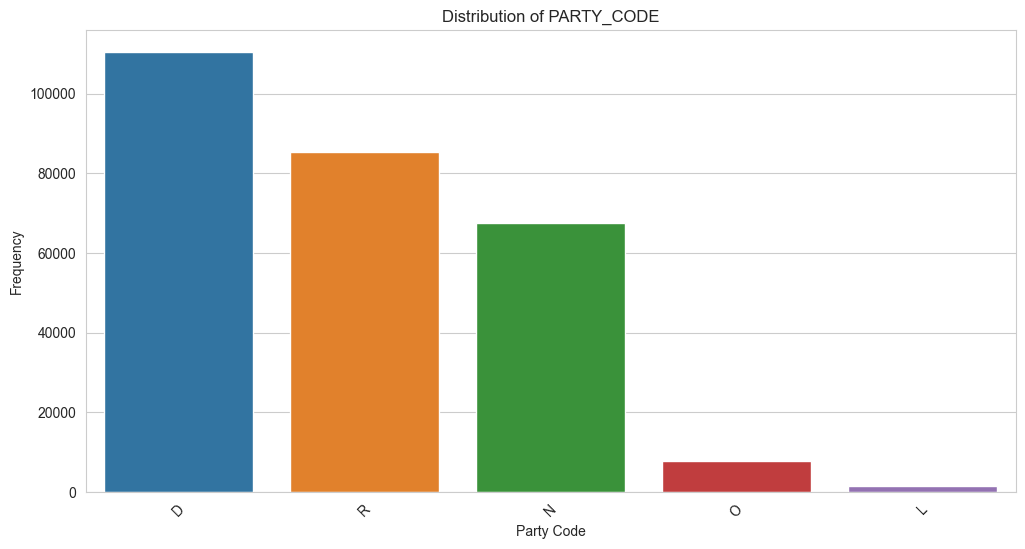

Counts for each category in PARTY_CODE:
PARTY_CODE
D    110365
R     85218
N     67573
O      7800
L      1563
Name: count, dtype: int64


In [21]:
# Generate a bar plot for 'PARTY_CODE'
plt.figure(figsize=(12, 6))
sns.countplot(data=engineered_data, x='PARTY_CODE', order=engineered_data['PARTY_CODE'].value_counts().index)
plt.title('Distribution of PARTY_CODE')
plt.xlabel('Party Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Display statistics
party_code_counts = engineered_data['PARTY_CODE'].value_counts()
print("Counts for each category in PARTY_CODE:")
print(party_code_counts)

In [ ]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=100000, num_runs=1, top_N_features=10):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        # Use all available columns except the target column 'PARTY_CODE'
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['PARTY_CODE'].notna()]
        
        if 'INFER_PARTY' in data_with_all_columns.columns:
            data_with_all_columns.drop('INFER_PARTY', axis=1, inplace=True)


        print("number of columns in the dataset", len(data_with_all_columns.columns))
        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)
        
        class_counts = data_sample['PARTY_CODE'].value_counts()
        valid_classes = class_counts[class_counts >= 2].index.tolist()
        data_sample = data_sample[data_sample['PARTY_CODE'].isin(valid_classes)]
        
        le = LabelEncoder()
        data_sample['PARTY_CODE'] = le.fit_transform(data_sample['PARTY_CODE'].astype(str))
        
        # Identify numeric and non-numeric columns
        numeric_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns.difference(['PARTY_CODE'])
        non_numeric_cols = data_sample.select_dtypes(exclude=['int64', 'float64']).columns.difference(['PARTY_CODE'])
        
        # One-hot encode non-numeric columns
        data_one_hot = pd.get_dummies(data_sample, columns=non_numeric_cols, drop_first=True)
        
        X = data_one_hot.drop('PARTY_CODE', axis=1)
        y = data_one_hot['PARTY_CODE']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Handle special characters in column names that XGBoost doesn't like
        X_train.columns = X_train.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        X_test.columns = X_test.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        
        xgb = XGBClassifier(objective='multi:softmax', random_state=42)
        xgb.fit(X_train, y_train)
        
        # Print feature importances
        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        print("Top 10 Important Features and Their Importances for Run {}: ".format(run))
        for index in sorted_idx:
            print(f"{X_train.columns[index]}: {feature_importances[index]}")


        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)

        print(f"Run {run} - Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    results_df = pd.DataFrame(results_list)
    
    return results_df

# Assuming engineered_data is already defined
result = run_xgboost_all_columns(final_data, sample_size=250000, num_runs=1, top_N_features=10)
result

In [ ]:
result['Top_N_Features']

In [ ]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=10000, num_runs=1, top_N_features=10):
    results_list = []
    all_features = [col for col in data.columns if col != 'INFER_PARTY']
    
    for exclude_feature in all_features:
        for run in range(1, num_runs + 1):
            data_with_all_columns = data.copy()
            data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
            if 'PARTY_CODE' in data_with_all_columns.columns:
                data_with_all_columns.drop('PARTY_CODE', axis=1, inplace=True)
            
            data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)
            
            class_counts = data_sample['INFER_PARTY'].value_counts()
            valid_classes = class_counts[class_counts >= 2].index.tolist()
            data_sample = data_sample[data_sample['INFER_PARTY'].isin(valid_classes)]
            
            le = LabelEncoder()
            data_sample['INFER_PARTY'] = le.fit_transform(data_sample['INFER_PARTY'].astype(str))
            
            if len(data_sample['INFER_PARTY'].unique()) < 2:
                continue
            
            numeric_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns.difference(['INFER_PARTY'])
            non_numeric_cols = data_sample.select_dtypes(exclude=['int64', 'float64']).columns.difference(['INFER_PARTY'])
            
            data_one_hot = pd.get_dummies(data_sample[non_numeric_cols], drop_first=True)
            
            final_data = pd.concat([data_one_hot, data_sample[numeric_cols], data_sample['INFER_PARTY']], axis=1)
            
            # Remove unsupported characters in feature names
            final_data.columns = final_data.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
            
            final_data = final_data.drop(columns=[exclude_feature], errors='ignore')

            X = final_data.drop('INFER_PARTY', axis=1)
            y = final_data['INFER_PARTY']
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
            
            xgb = XGBClassifier(objective='multi:softmax', num_class=len(valid_classes), random_state=42)
            xgb.fit(X_train, y_train)
            
            y_pred = xgb.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)

            feature_importances = xgb.feature_importances_
            sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
            top_features = X.columns[sorted_idx].tolist()

            results_list.append({
                'Run': run,
                'Excluded_Feature': exclude_feature,
                'Accuracy': accuracy,
                'F1_Score': f1,
                'Recall': recall,
                'Top_N_Features': top_features
            })

    result_ablation = pd.DataFrame(results_list)
    return result_ablation

# Assuming engineered_data is already defined
result_ablation_infer_party = run_xgboost_all_columns(final_data, sample_size=10000, num_runs=1, top_N_features=20)

In [ ]:
result_ablation_infer_party

In [ ]:
result_ablation_infer_party.to_csv('/Users/nirugidla/Documents/GitHub/milestone2_MADS/result_ablation_infer_party_df.csv', index=False)

In [29]:
# Step 2: Read the CSV file
result_ablation_infer_party = pd.read_csv('/Users/nirugidla/Documents/GitHub/milestone2_MADS/result_ablation_infer_party_df.csv')

# Step 3: Visualize
# Plotting Accuracy
fig = px.line(result_ablation_infer_party, x='Excluded_Feature', y='Accuracy', title='Accuracy vs Excluded Feature')
fig.show()

# Plotting F1 Score
fig = px.line(result_ablation_infer_party, x='Excluded_Feature', y='F1_Score', title='F1 Score vs Excluded Feature')
fig.show()

# Plotting Recall
fig = px.line(result_ablation_infer_party, x='Excluded_Feature', y='Recall', title='Recall vs Excluded Feature')
fig.show()

In [ ]:
# Step 1: Get the baseline metrics
# baseline_accuracy = 0.9329
# baseline_f1_score = 0.9205910012701286
# baseline_recall = 0.9329
baseline_accuracy = 0.7746333333333333
baseline_f1_score = 0.7655605256770346
baseline_recall = 0.777394366197183

# baseline_accuracy = 0.86
# baseline_f1_score = 0.86
# baseline_recall = 0.86

# Define a threshold for acceptable performance drop. For example, 1% drop.
threshold = 0.0055

# Step 2 and 3: Identify features that can be removed
features_to_remove = []

for _, row in result_ablation_infer_party.iterrows():
    if abs(row['Accuracy'] - baseline_accuracy) <= threshold and \
       abs(row['F1_Score'] - baseline_f1_score) <= threshold and \
       abs(row['Recall'] - baseline_recall) <= threshold:
        features_to_remove.append(row['Excluded_Feature'])

# Remove duplicates if any
features_to_remove = list(set(features_to_remove))

# Now features_to_remove contains the list of features that can be safely removed
print("Features to remove:", features_to_remove)
print("Number Features to remove:", len(features_to_remove))

In [ ]:
result_ablation_infer_party

In [ ]:
#####

In [ ]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=150000, num_runs=1, top_N_features=10):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        # Use 'INFER_PARTY' as the target variable and remove 'PARTY_CODE'
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
        if 'PARTY_CODE' in data_with_all_columns.columns:
            data_with_all_columns.drop('PARTY_CODE', axis=1, inplace=True)

        print("Number of columns in the dataset:", len(data_with_all_columns.columns))

        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)
        
        class_counts = data_sample['INFER_PARTY'].value_counts()
        valid_classes = class_counts[class_counts >= 2].index.tolist()
        data_sample = data_sample[data_sample['INFER_PARTY'].isin(valid_classes)]

        if len(valid_classes) > 1:  # Only continue if there are at least two classes to predict
            le = LabelEncoder()
            data_sample['INFER_PARTY'] = le.fit_transform(data_sample['INFER_PARTY'].astype(str))

            #numeric_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns.difference(['INFER_PARTY'])
            non_numeric_cols = data_sample.select_dtypes(exclude=['int64', 'float64']).columns.difference(['INFER_PARTY'])

            data_one_hot = pd.get_dummies(data_sample, columns=non_numeric_cols, drop_first=True)

            X = data_one_hot.drop('INFER_PARTY', axis=1)
            y = data_one_hot['INFER_PARTY']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

            X_train.columns = X_train.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
            X_test.columns = X_test.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
            
            xgb = XGBClassifier(objective='multi:softmax', num_class=len(valid_classes), random_state=42)
            xgb.fit(X_train, y_train)

            y_pred = xgb.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)

            print(f"Run {run} - Baseline Metrics: Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}")

            feature_importances = xgb.feature_importances_
            sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
            top_features = X.columns[sorted_idx].tolist()

            results_list.append({
                'Run': run,
                'Accuracy': accuracy,
                'F1_Score': f1,
                'Recall': recall,
                'Top_N_Features': top_features
            })
        else:
            print(f"Run {run} skipped as there are not enough classes to perform classification.")

    results_df = pd.DataFrame(results_list)
    return results_df

# Assuming engineered_data is already defined
result = run_xgboost_all_columns(engineered_data, sample_size=150000, num_runs=1, top_N_features=10)
result

In [ ]:
def plot_feature_importance(importance, names, model_type, top_N_features=10):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    sorted_idx = feature_importance.argsort()[-top_N_features:]
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='blue')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Importance')
    plt.title(model_type + ' - Feature Importance')
    plt.show()

@timer_decorator
def run_xgboost_all_columns(data, sample_size=100000, num_runs=1, top_N_features=10):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        # Use all available columns except the target column 'PARTY_CODE'
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['PARTY_CODE'].notna()]
        print("number of columns in the dataset", len(data_with_all_columns.columns))
        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)
        
        class_counts = data_sample['PARTY_CODE'].value_counts()
        valid_classes = class_counts[class_counts >= 2].index.tolist()
        data_sample = data_sample[data_sample['PARTY_CODE'].isin(valid_classes)]
        
        le = LabelEncoder()
        data_sample['PARTY_CODE'] = le.fit_transform(data_sample['PARTY_CODE'].astype(str))
        
        # Identify numeric and non-numeric columns
        numeric_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns.difference(['PARTY_CODE'])
        non_numeric_cols = data_sample.select_dtypes(exclude=['int64', 'float64']).columns.difference(['PARTY_CODE'])
        
        # One-hot encode non-numeric columns
        data_one_hot = pd.get_dummies(data_sample[non_numeric_cols], drop_first=True)
        
        # Combine back with the numeric columns and the target variable
        final_data = pd.concat([data_one_hot, data_sample[numeric_cols], data_sample['PARTY_CODE']], axis=1)
        
        X = final_data.drop('PARTY_CODE', axis=1)
        y = final_data['PARTY_CODE']
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Handle special characters in column names that XGBoost doesn't like
        X_train.columns = X_train.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        X_test.columns = X_test.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        
        xgb = XGBClassifier(objective='multi:softmax', random_state=42)
        xgb.fit(X_train, y_train)
        
        # Print feature importances
        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        print("Top 10 Important Features and Their Importances for Run {}: ".format(run))
        for index in sorted_idx:
            print(f"{X_train.columns[index]}: {feature_importances[index]}")

        # Plot feature importances
        plot_feature_importance(xgb.feature_importances_, X_train.columns, 'XGBoost', top_N_features=top_N_features)

        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        print(f"Run {run} - Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    results_df = pd.DataFrame(results_list)
    
    return results_df
# Assuming engineered_data is already defined
result = run_xgboost_all_columns(engineered_data, sample_size=50000, num_runs=2, top_N_features=10)
result

In [ ]:
# Remove 'INFER_PARTY_R' from the dataset
engineered_data_ablation = engineered_data.drop(columns=['INFER_PARTY_R'])

# Retrain and evaluate the model
result_ablation = run_xgboost_all_columns(engineered_data_ablation, sample_size=50000, num_runs=2, top_N_features=10)
result_ablation

In [ ]:
def plot_feature_importance(importance, names, model_type, top_N_features=10):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    sorted_idx = feature_importance.argsort()[-top_N_features:]
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='blue')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Importance')
    plt.title(model_type + ' - Feature Importance')
    plt.show()

@timer_decorator
def run_xgboost_all_columns(data, sample_size=100000, num_runs=1, top_N_features=10, exclude_features=None):
    results_list = []
    if exclude_features is None:
        exclude_features = []

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        # Use all available columns except the target column 'PARTY_CODE'
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['PARTY_CODE'].notna()]
        print("number of columns in the dataset", len(data_with_all_columns.columns))
        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)
        
        class_counts = data_sample['PARTY_CODE'].value_counts()
        valid_classes = class_counts[class_counts >= 2].index.tolist()
        data_sample = data_sample[data_sample['PARTY_CODE'].isin(valid_classes)]
        
        le = LabelEncoder()
        data_sample['PARTY_CODE'] = le.fit_transform(data_sample['PARTY_CODE'].astype(str))
        
        # Identify numeric and non-numeric columns
        numeric_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns.difference(['PARTY_CODE'])
        non_numeric_cols = data_sample.select_dtypes(exclude=['int64', 'float64']).columns.difference(['PARTY_CODE'])
        
        # One-hot encode non-numeric columns
        data_one_hot = pd.get_dummies(data_sample[non_numeric_cols], drop_first=True)
        
        # Combine back with the numeric columns and the target variable
        final_data = pd.concat([data_one_hot, data_sample[numeric_cols], data_sample['PARTY_CODE']], axis=1)
        
        # Remove excluded features if any
        final_data = final_data.drop(columns=exclude_features, errors='ignore')

        X = final_data.drop('PARTY_CODE', axis=1)
        y = final_data['PARTY_CODE']
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Handle special characters in column names that XGBoost doesn't like
        X_train.columns = X_train.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        X_test.columns = X_test.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        
        xgb = XGBClassifier(objective='multi:softmax', random_state=42)
        xgb.fit(X_train, y_train)
        
        # Print feature importances
        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        print("Top 10 Important Features and Their Importances for Run {}: ".format(run))
        for index in sorted_idx:
            print(f"{X_train.columns[index]}: {feature_importances[index]}")

        # Plot feature importances
        plot_feature_importance(xgb.feature_importances_, X_train.columns, 'XGBoost', top_N_features=top_N_features)

        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        print(f"Run {run} - Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    results_df = pd.DataFrame(results_list)
    
    return results_df
# Assuming engineered_data is already defined
# result = run_xgboost_all_columns(engineered_data, sample_size=50000, num_runs=2, top_N_features=10)
# result
result_ablation = run_xgboost_all_columns(engineered_data, sample_size=50000, num_runs=2, top_N_features=10, exclude_features=['INFER_PARTY_R'])
result_ablation

In [ ]:
@timer_decorator
def run_feature_ablation(engineered_data, sample_size=50000, num_runs=1, top_N_features=10):
    ablation_results = []  # List to store the results

    all_columns = engineered_data.columns.tolist()
    all_columns.remove('PARTY_CODE')  # Remove the target variable

    for feature in all_columns:
        print(f"Running ablation by excluding feature: {feature}")
        result = run_xgboost_all_columns(engineered_data, sample_size=sample_size, num_runs=num_runs, top_N_features=top_N_features, exclude_features=[feature])
        
        # Assuming the first run's metrics are stored in result.iloc[0]
        metrics = result.iloc[0].to_dict()
        metrics['Excluded_Feature'] = feature  # Add the excluded feature to the metrics
        
        ablation_results.append(metrics)

    # Convert the list of results to a DataFrame
    ablation_results_df = pd.DataFrame(ablation_results)
    
    return ablation_results_df

# Run the feature ablation
ablation_results_df = run_feature_ablation(engineered_data, sample_size=50000, num_runs=1, top_N_features=10)
#ablation_results_df
# Save the DataFrame to a CSV file if you want
# ablation_results_df.to_csv("/path/to/save/ablation_results.csv", index=False)

In [ ]:
ablation_results_df.to_csv('/Users/nirugidla/Downloads/ablation_results_df.csv', index=False)


In [ ]:
ablation_results_df_copy = pd.read_csv("/Users/nirugidla/Downloads/ablation_results_df.csv")

In [ ]:
# Sorting the DataFrame by 'Accuracy' to understand which feature removal has the greatest impact on accuracy
sorted_by_accuracy = ablation_results_df_copy.sort_values(by='Accuracy', ascending=False)

# Displaying the sorted DataFrame to show features with the greatest impact when removed
sorted_by_accuracy.head()

In [ ]:
# Assuming ablation_results_df is already defined in your environment

# Sorting the DataFrame by 'Accuracy' to understand which feature removal has the greatest impact on accuracy
sorted_by_accuracy = ablation_results_df_copy.sort_values(by='Accuracy', ascending=False)

# Plotting the metrics as features are excluded
plt.figure(figsize=(20, 8))

# Creating subplots for each metric: Accuracy, F1 Score, and Recall
for idx, metric in enumerate(['Accuracy', 'F1_Score', 'Recall'], 1):
    plt.subplot(1, 3, idx)
    sns.boxplot(data=ablation_results_df_copy, x='Excluded_Feature', y=metric)
    plt.title(f"{metric} vs Excluded Features")
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# Importing the Plotly library for interactive plots
# Creating subplots for each metric: Accuracy, F1 Score, and Recall
fig = px.box(ablation_results_df_copy.melt(id_vars='Excluded_Feature', value_vars=['Accuracy', 'F1_Score', 'Recall']),
             x='Excluded_Feature', y='value', color='variable',
             labels={'value': 'Metric Value', 'Excluded_Feature': 'Excluded Feature'},
             title='Metrics vs Excluded Features')

# Updating layout for better readability
fig.update_layout(
    xaxis_title='Excluded Features',
    yaxis_title='Metric Value',
    boxmode='group'  # group together boxes of the same type
)
fig.update_xaxes(categoryorder='total ascending')

fig.show()

In [ ]:
import plotly.graph_objects as go

# Prepare data for plot
melted_df = ablation_results_df_copy.melt(id_vars='Excluded_Feature', value_vars=['Accuracy', 'F1_Score', 'Recall'])

# Create subplots
fig = go.Figure()

metrics = ['Accuracy', 'F1_Score', 'Recall']
colors = ['red', 'green', 'blue']

for metric, color in zip(metrics, colors):
    subset = melted_df[melted_df['variable'] == metric]
    fig.add_trace(go.Box(
        y=subset['value'],
        x=subset['Excluded_Feature'],
        name=metric,
        marker=dict(
            color=color,
            line=dict(
                width=2,
            )
        )
    ))

# Update layout
fig.update_layout(
    xaxis_title='Excluded Features',
    yaxis_title='Metric Value',
    title='Metrics vs Excluded Features',
    boxmode='group'
)
fig.update_xaxes(categoryorder='total ascending')

fig.show()


In [ ]:
import plotly.express as px

# Assuming ablation_results_df_copy is the DataFrame you're working with
# Melt the DataFrame to make it suitable for line plots
melted_df = ablation_results_df_copy.melt(id_vars='Excluded_Feature', value_vars=['Accuracy', 'F1_Score', 'Recall'])

# Create the line plot
fig = px.line(melted_df, x='Excluded_Feature', y='value', color='variable', 
              labels={'value': 'Metric Value', 'Excluded_Feature': 'Excluded Feature'},
              title='Metrics vs Excluded Features')

# Update layout for better readability
fig.update_layout(
    xaxis_title='Excluded Features',
    yaxis_title='Metric Value'
)
fig.update_xaxes(categoryorder='total ascending')

fig.show()